# Deep Learning - Spring 2020 - HW3 - Question 3

Students:


*   Inbar Hasidim 206106213
*   Samuel Londner 336072780


In this part we implement the paper "[Semi-supervised Learning withDeep Generative Models](https://papers.nips.cc/paper/5352-semi-supervised-learning-with-deep-generative-models.pdf)" by Kingma et al. We focus on the M1 algorithm.

The basic idea is to train a variational autoencoder (VAE), then use the encoder only to extract features and train a classifier (here, a SVM) on the features.

## Setup

### Imports

In [5]:
import numpy as np
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import datetime
import matplotlib.pyplot as plt
import random
from sklearn import svm
%tensorflow_version 2.x
from tensorflow import summary
%load_ext tensorboard

from sklearn.preprocessing import minmax_scale
import pandas as pd
from IPython.display import display
import pickle

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


### Dataset

The following function returns a certain number of samples from a certain number of labels, making sure sure every class appears in the same number of samples.

Note that in the original paper the researchers treat every image as if it was a Bernoulli distribution from which we sample and feed to the network. The last layer in the network will contain the reconstructed "distribution", which is the reconstructed image itself. In practice we could not see any meaningful difference in performance.

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



flatten_transform = lambda x: transforms.ToTensor()(x).view(-1)

test_dataset = datasets.FashionMNIST('../data', train=False, transform=flatten_transform, download=True)
train_dataset = torchvision.datasets.FashionMNIST('/data', train=True,transform=flatten_transform,target_transform=None, download=True)

# flatten_bernoulli = lambda x: transforms.ToTensor()(x).view(-1).bernoulli()

def get_loader(dataset, number_of_samples, num_classes = 10):
  # random.seed(2020) # constant seed for reproducibility
  torch.manual_seed(2020)
  samples_per_class=int(number_of_samples/num_classes)
  labels = dataset.targets.numpy().squeeze()

  # Get only data from required classes and appropriate number of samples
  all_idx=list()
  for cls in range(num_classes):
    idxs = np.argwhere(labels==cls)
    np.random.seed(2020)
    sample = np.random.choice(idxs.shape[0], samples_per_class, replace=False) 
    idxs=idxs[sample]
    all_idx+=list(idxs.squeeze())
  random.seed(2020)
  random.shuffle(all_idx)
  sampler = torch.utils.data.sampler.SubsetRandomSampler(all_idx)    

  train_loader = torch.utils.data.DataLoader(dataset,
                                        sampler = sampler,
                                        num_workers=4,
                                        batch_size=len(dataset))
  return train_loader

Extracting ../data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw



Extracting ../data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ../data/FashionMNIST/raw


Extracting ../data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/FashionMNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


### Variational Autoencoder Class

This [article](http://bjlkeng.github.io/posts/semi-supervised-learning-with-variational-autoencoders/) and [this one](http://bjlkeng.github.io/posts/variational-autoencoders/) helped us very much in understanding the functioning of a VAE.

This [notebook](https://github.com/wohlert/semi-supervised-pytorch/blob/master/examples/notebooks/Variational%20Autoencoder.ipynb) provided an implementation which we loosely got inspiration from (the model implementation is [here](https://github.com/wohlert/semi-supervised-pytorch/blob/master/semi-supervised/models/vae.py)).

In [3]:
class VAE(nn.Module):
  def __init__(self, x_dim=784, hidden_dims=(600,600), z_dim=50, activation=torch.nn.Softplus(), 
               output_activation = nn.Sigmoid()):
  # def __init__(self, dims = (784, 600, 600), z_dim=50):
    '''
    Args:
        x_dim: A integer indicating the size of input (in case of MNIST 28 * 28).
        hidden_dim: A tuple indicating the number and size of hidden layers.
        z_dim: A integer indicating the latent variable dimension.
    '''
    super(VAE, self).__init__()

    # Encoder 
    neurons = [x_dim, *hidden_dims]
    self.encoder = nn.ModuleList(
        [nn.Linear(neurons[i-1], neurons[i]) for i in range(1, len(neurons))]
    )

    # Gaussian Sampler
    # self.linear = nn.Linear(input_dim, hidden_dim)
    self.mu_layer = nn.Linear(hidden_dims[-1], z_dim)
    self.log_var_layer = nn.Linear(hidden_dims[-1], z_dim)
    
    # Decoder
    dneurons = [z_dim, *hidden_dims[::-1]]
    self.decoder = nn.ModuleList(
        [nn.Linear(dneurons[i-1], dneurons[i]) for i in range(1, len(dneurons))]
    )

    self.out_layer = nn.Linear(hidden_dims[0], x_dim)

    # Activation functions
    self.activation = activation
    self.output_activation = output_activation

    # Init weights
    for m in self.modules():
      if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight.data)
        if m.bias is not None:
          m.bias.data.zero_()
  
  def reparameterize(self, mu, log_var):
    std = torch.exp(0.5*log_var)
    eps = torch.randn_like(std)
    return mu + eps*std

  def encode(self,x):
    for layer in self.encoder:
      x = self.activation(layer(x))
    # Stochastic parameters
    mu = self.mu_layer(x)
    log_var = self.log_var_layer(x)
    # Sample from Gaussian using reparameterizing
    z = self.reparameterize(mu, log_var)
    return z, mu, log_var
  
  def decode(self,z):
    for layer in self.decoder:
      z = self.activation(layer(z))
    x = self.output_activation(self.out_layer(z))
    return x


  def forward(self, x):
    z, mu, log_var = self.encode(x)
    r = self.decode(z)

    return r, mu, log_var   

### Loss function 
We now define the loss function, the variational lower bound (or more precisely its reprocical, since the default PyTorch backpropagation algorithm *minimizes* the objective):

In [ ]:
# Compute variational lower bound - the loss
def elbo(mu, log_var, x, r):
  #Compute KL divergence between  q(z|x)~N(z|\mu_enc, var_enc) and p(z)~N(z|0,I) : KL(q || p(z))
  # Formula from https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions
  # See also https://arxiv.org/abs/1312.6114 Appendix B
  kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

  # According to https://github.com/dpkingma/nips14-ssl/blob/1fc7aec899ca429ff26a1d10f747e5ad6bcd17b2/anglepy/models/GPUVAE_YZ_X.py#L107
  logpx = F.binary_cross_entropy(r,x.view(-1, 784),reduction='sum')

  return kl_div + logpx

## Train VAE

### Training

In [ ]:
model = VAE(hidden_dims = (600,600)).to(device)
print(model)

VAE(
  (encoder): ModuleList(
    (0): Linear(in_features=784, out_features=600, bias=True)
    (1): Linear(in_features=600, out_features=600, bias=True)
  )
  (mu_layer): Linear(in_features=600, out_features=50, bias=True)
  (log_var_layer): Linear(in_features=600, out_features=50, bias=True)
  (decoder): ModuleList(
    (0): Linear(in_features=50, out_features=600, bias=True)
    (1): Linear(in_features=600, out_features=600, bias=True)
  )
  (out_layer): Linear(in_features=600, out_features=784, bias=True)
  (activation): Softplus(beta=1, threshold=20)
  (output_activation): Sigmoid()
)


We train the VAE on the whole training set:

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, betas=(0.9, 0.999))

train_data_vae = torch.utils.data.DataLoader(train_dataset,shuffle=False, batch_size=128, num_workers=4)
test_data_vae = torch.utils.data.DataLoader(test_dataset,shuffle=False, batch_size=128, num_workers=4)

train_losses = []
test_losses = []
for epoch in range(101):
  model.train()
  total_train_loss = 0
  for (u, _) in train_data_vae:
    u = u.to(device)
    optimizer.zero_grad()
    reconstruction, mu, log_var = model(u)     
    L = elbo(mu, log_var, u, reconstruction)
    L.backward()
    optimizer.step()
    total_train_loss += L.item()/len(u)

  train_losses.append(total_train_loss/len(train_data_vae))

  #Test
  model.eval()
  total_test_loss = 0
  for (u, _) in train_data_vae:
    u = u.to(device)
    reconstruction, mu, log_var = model(u)     
    L = elbo(mu, log_var, u, reconstruction)
    total_test_loss += L.item()/len(u)
  test_losses.append(total_test_loss/len(test_data_vae))

  if epoch % 10 == 0:
    print(f"Epoch: {epoch}\tTrain Loss: {train_losses[-1]:.2f}\tTest Loss: {test_losses[-1]:.2f}")

Epoch: 0	Train Loss: 322.89	Test Loss: 1692.83
Epoch: 10	Train Loss: 243.84	Test Loss: 1444.51
Epoch: 20	Train Loss: 239.87	Test Loss: 1422.23
Epoch: 30	Train Loss: 238.09	Test Loss: 1413.73
Epoch: 40	Train Loss: 236.97	Test Loss: 1406.10
Epoch: 50	Train Loss: 236.25	Test Loss: 1402.10
Epoch: 60	Train Loss: 235.73	Test Loss: 1398.68
Epoch: 70	Train Loss: 235.30	Test Loss: 1396.56
Epoch: 80	Train Loss: 234.99	Test Loss: 1394.32
Epoch: 90	Train Loss: 234.71	Test Loss: 1393.44
Epoch: 100	Train Loss: 234.46	Test Loss: 1390.71


We display the losses:

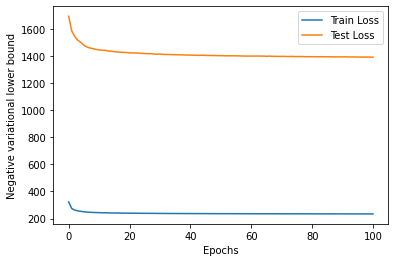

In [ ]:
plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(test_losses, label="Test Loss")
plt.xlabel('Epochs')
plt.ylabel("Negative variational lower bound")
plt.legend()
plt.show()

### Generating

We check the generator by creating some new samples:

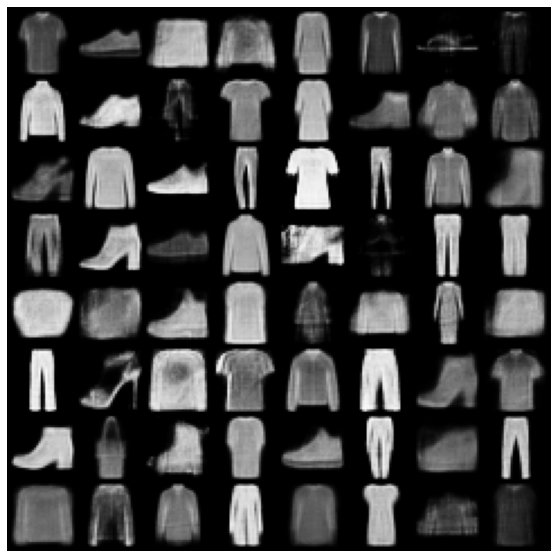

In [ ]:
model.eval()
noise_input = torch.autograd.Variable(torch.randn(64,1, 1, 50)).to(device)
x_mu = model.decode(noise_input)
samples = x_mu.data.view(-1,1, 28, 28)

grid_imgs = torchvision.utils.make_grid(samples)
np_grid_imgs = grid_imgs.cpu().numpy()
plt.figure(figsize=(15,10))
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
plt.axis("off")
plt.show()

We also check a sample reconstruction:

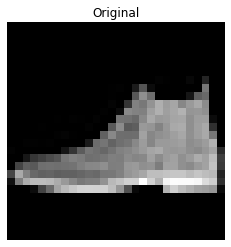

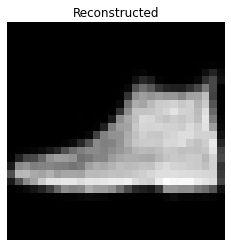

In [ ]:
test_loader = torch.utils.data.DataLoader(test_dataset,shuffle=False)
model.eval()
with torch.no_grad():
    for i, (data, _) in enumerate(test_loader):
      if (i>0):
        break
      data = data.to(device)
      recon_batch, mu, logvar = model(data)
      samples = recon_batch.data.view(-1, 28, 28).cpu().numpy()
      plt.imshow(data.view(-1, 28, 28).cpu().numpy().squeeze(),  cmap='gray')
      plt.axis("off")
      plt.title("Original")
      plt.show()
      plt.imshow(samples[0,:,:], cmap='gray')
      plt.axis("off")
      plt.title("Reconstructed")
      plt.show()
      #TODO: make subplots

## Classification

### Encode data to feature space

We get the whole testing data and encode it to the latent space:

In [ ]:
model.eval()
test_loader_svm = torch.utils.data.DataLoader(train_dataset,shuffle=False, batch_size=len(train_dataset))
test_x_tensor, test_y_tensor = next(iter(test_loader_svm))
print(test_x_tensor.shape)
test_z = model.encode(test_x_tensor.to(device))[0].detach().cpu().numpy()

test_x = test_x_tensor.cpu().numpy()
test_y = test_y_tensor.cpu().numpy()

torch.Size([60000, 784])


### Classify

We now train SVM classifiers on the latent space represenation of the training set, with various number of samples.

We used the default sklearn SVM kernel - "rbf" with gamma coefficient 1 / (n_features * X.var()). Other kernels gave similar results.

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Binarizer

nums_samples = [100, 600, 1000, 3000]
df = pd.DataFrame(columns = ["Train", 'Test'])

clfs = []

for number_of_samples in nums_samples:
  #Load data
  train_data_svm = get_loader(dataset=train_dataset, number_of_samples=number_of_samples)
  train_x_tensor, train_y_tensor = next(iter(train_data_svm))
  train_z = model.encode(train_x_tensor.to(device))[0].detach().cpu().numpy()

  train_x = train_x_tensor.cpu().numpy()
  train_y = train_y_tensor.cpu().numpy()

  #Train SVM
  clf_latent = svm.SVC()
  clf_latent.fit(train_z, train_y)

  accuracies = {}

  #Test SVM
  #Train set
  y_predicted_latent = clf_latent.predict(train_z)
  train_error = 100 - 100*np.count_nonzero(train_y==y_predicted_latent) / np.size(train_y)

  # Test set
  y_predicted_latent = clf_latent.predict(test_z)
  test_error = 100 - 100*np.count_nonzero(test_y==y_predicted_latent) / np.size(test_y)

  df = df.append(pd.Series({'Train':round(train_error,2), 'Test':round(test_error,2)}, name = number_of_samples))
  clfs.append(clf_latent)


We display the error rates in percents, like in the original paper:

In [ ]:
df

,Train,Test
100,0.00,64.49
600,0.83,40.03
1000,2.10,34.34
3000,5.33,27.64


## Conclusions

It should be noted that the results are not exceptional and SVM trained on the direct representation of the data give comparable (if not superior) results.

We surmise the reasons for the poor performance of the classifier are:
- the use of a regular SVM and not a transductive SVM.
- the complexity of the FashionMNIST dataset compared to the MNIST dataset. Increasing the dimension of the latent space may improve results.

Another matter of interest is that as the training set get smaller, the error rate on the training set gets *lower*. This happens because the classifier overfits more easily on a small dataset.

Lastly, we should note that a surpising improvement was reached by using only the cross-entropy loss in the VAE training (and zeroing the KL divergence component). The resulting images were pretty bad, but it turned out the performance of the SVM trained on the resulting features were consistently superior:

Samples number | Train | Test
--- | --- | ---
100 | 12.00 | 30.17
600 | 12.33 | 20.98
1000 | 12.00 | 18.43
3000 | 11.33 | 15.75

To be honest we do not have any definite explanation for this improvement. Since this is not mentioned in the original paper, we mention it for the sake of completeness.

## Save weights

In [ ]:
torch.save(model.state_dict(), 'Q3-VAE.pth')

pickle.dump( clfs, open( "Q3-SVMs.p", "wb" ) )

## Load weights and test models

Upload to the Colab virtual system the above files (which should be in the current Google Drive folder) and run the following command (note that the imports and the model class definition should have been run):

In [6]:
model_loaded = VAE(hidden_dims = (600,600)).to(device)
model_loaded.load_state_dict(torch.load('Q3-VAE.pth'))
model_loaded.eval()
clfs = pickle.load(open( "Q3-SVMs.p", "rb" ))

We print the $\gamma$ parameters of the SVM classifiers:

In [ ]:
for c in clfs:
  print(c._gamma)

0.020323396589249098
0.019912771889842012
0.019858484302113812
0.019920799271178832


Test the encoder:

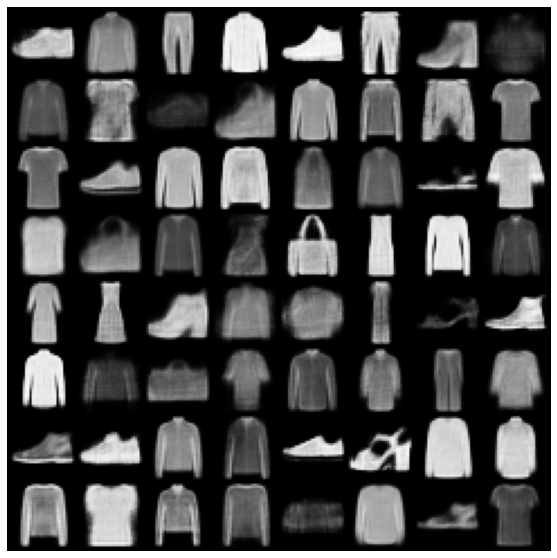

In [ ]:
noise_input = torch.autograd.Variable(torch.randn(64,1, 1, 50)).to(device)
x_mu = model_loaded.decode(noise_input)
samples = x_mu.data.view(-1,1, 28, 28)

grid_imgs = torchvision.utils.make_grid(samples)
np_grid_imgs = grid_imgs.cpu().numpy()
plt.figure(figsize=(15,10))
plt.imshow(np.transpose(np_grid_imgs, (1,2,0)))
plt.axis("off")
plt.show()

Test the SVMs (we assume the train and test data have been loaded and properly encoded):

In [ ]:
nums_samples = [100, 600, 1000, 3000]
df = pd.DataFrame(columns = ["Train", 'Test'])

for clf_latent, number_of_samples in zip(clfs,nums_samples):
  train_data_svm = get_loader(dataset=train_dataset, number_of_samples=number_of_samples)
  train_x_tensor, train_y_tensor = next(iter(train_data_svm))
  train_z = model.encode(train_x_tensor.to(device))[0].detach().cpu().numpy()

  train_x = train_x_tensor.cpu().numpy()
  train_y = train_y_tensor.cpu().numpy()
  #Train set
  y_predicted_latent = clf_latent.predict(train_z)
  train_error = 100 - 100*np.count_nonzero(train_y==y_predicted_latent) / np.size(train_y)
  # Test set
  y_predicted_latent = clf_latent.predict(test_z)
  test_error = 100 - 100*np.count_nonzero(test_y==y_predicted_latent) / np.size(test_y)
  df = df.append(pd.Series({'Train':round(train_error,2), 'Test':round(test_error,2)}, name = number_of_samples))
display(df)

,Train,Test
100,0.00,64.49
600,0.83,40.03
1000,2.10,34.34
3000,5.33,27.64
